In [1]:
!unzip -O 'cp949' "2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_데이터_210803.zip"

Archive:  2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_데이터_210803.zip
   creating: 2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_데이터_210803/01_제공데이터/
  inflating: 2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_데이터_210803/01_제공데이터/2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_댐유입량,강우,수위데이터_210803.xlsx  
   creating: 2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_데이터_210803/02_평가데이터/
  inflating: 2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_데이터_210803/02_평가데이터/2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_평가데이터_210803.xlsx  


In [2]:
## https://dacon.io/competitions/official/235689/overview/description

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split

base='2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_데이터_210803/'
train_folder='01_제공데이터/'

data=pd.read_excel(base+train_folder+'2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_댐유입량,강우,수위데이터_210803.xlsx')

cols=['홍수사상번호','연','월','일','시간','유입량']

for i in range(1,7):
    prefix=f'데이터집단{i}_'
    cols.append(prefix+'유역평균강수')
    cols.append(prefix+'강우(A지역)')
    cols.append(prefix+'강우(B지역)')
    cols.append(prefix+'강우(C지역)')
    cols.append(prefix+'강우(D지역)')
    cols.append(prefix+'수위(E지역)')
    cols.append(prefix+'수위(B지역)')

data=data.drop(0).reset_index(drop=True)
data.columns=cols

for idx,col in enumerate(cols):
    if idx<5:
        data[col]=data[col].astype(int)
    else:
        data[col]=data[col].astype(float)    
        
from datetime import datetime,timedelta

data['time']=data.apply(lambda row:datetime(year=int(row['연']),month=int(row['월']),day=int(row['일'])),axis=1)
data['time']=data.apply(lambda row:row['time']+timedelta(hours=row['시간']),axis=1)

test=data.iloc[2891:]

submit=test[['홍수사상번호','연','월','일','시간']]
submit['유입량']=0

data=data.drop(['연','월','일','시간','time'],axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
## 전체 데이터를 대상으로 정규화
## 나중에 훈련할 때 train과 test에 data leakage문제에서 벗어나기 위해서

from sklearn.preprocessing import StandardScaler

for col in data.columns[1:]:
    if col=='유입량':
        mean=data[col].mean()
        std=data[col].std()
        data[col]=(data[col]-mean)/std
        continue
    ss=StandardScaler()
    data[col]=ss.fit_transform(data[col].values.reshape(-1,1))
data.head()

,홍수사상번호,유입량,데이터집단1_유역평균강수,데이터집단1_강우(A지역),데이터집단1_강우(B지역),데이터집단1_강우(C지역),데이터집단1_강우(D지역),데이터집단1_수위(E지역),데이터집단1_수위(B지역),데이터집단2_유역평균강수,데이터집단2_강우(A지역),데이터집단2_강우(B지역),데이터집단2_강우(C지역),데이터집단2_강우(D지역),데이터집단2_수위(E지역),데이터집단2_수위(B지역),데이터집단3_유역평균강수,데이터집단3_강우(A지역),데이터집단3_강우(B지역),데이터집단3_강우(C지역),데이터집단3_강우(D지역),데이터집단3_수위(E지역),데이터집단3_수위(B지역),데이터집단4_유역평균강수,데이터집단4_강우(A지역),데이터집단4_강우(B지역),데이터집단4_강우(C지역),데이터집단4_강우(D지역),데이터집단4_수위(E지역),데이터집단4_수위(B지역),데이터집단5_유역평균강수,데이터집단5_강우(A지역),데이터집단5_강우(B지역),데이터집단5_강우(C지역),데이터집단5_강우(D지역),데이터집단5_수위(E지역),데이터집단5_수위(B지역),데이터집단6_유역평균강수,데이터집단6_강우(A지역),데이터집단6_강우(B지역),데이터집단6_강우(C지역),데이터집단6_강우(D지역),데이터집단6_수위(E지역),데이터집단6_수위(B지역)
0,1,-0.714002,-1.036870,-0.988808,-0.905344,-0.712134,-0.808934,-0.852663,-1.480226,-1.047460,-1.017853,-0.898056,-0.708746,-0.808934,-0.852663,-1.496831,-1.047460,-1.017853,-0.842268,-0.714176,-0.815826,-0.852663,-1.502656,-1.054742,-1.032332,-0.842268,-0.828119,-0.839624,-0.852663,-1.438416,-1.039463,-1.032332,-0.842268,-0.828119,-0.839624,-0.852663,-1.447929,-0.989485,-1.032332,-0.850690,-0.690847,-0.819482,-0.852663,-1.462364
1,1,-0.701236,-1.038555,-0.988808,-0.889561,-0.712134,-0.808934,-0.856874,-1.481258,-1.045774,-1.017853,-0.882157,-0.708746,-0.808934,-0.856874,-1.495455,-1.045774,-1.017853,-0.825489,-0.714176,-0.815826,-0.856874,-1.501280,-1.039552,-1.032332,-0.825489,-0.789880,-0.804437,-0.856874,-1.439596,-1.024050,-1.032332,-0.825489,-0.789880,-0.804437,-0.856874,-1.449912,-0.973335,-1.032332,-0.834046,-0.646145,-0.783537,-0.856874,-1.464014
2,1,-0.685436,-1.036870,-0.988808,-0.873778,-0.712134,-0.808934,-0.856874,-1.482289,-1.030598,-1.017853,-0.866258,-0.708746,-0.808934,-0.856874,-1.494080,-1.030598,-1.017853,-0.808710,-0.692176,-0.815826,-0.856874,-1.499903,-1.024363,-1.032332,-0.808710,-0.789880,-0.786844,-0.856874,-1.440777,-1.008636,-1.032332,-0.808710,-0.789880,-0.786844,-0.856874,-1.451894,-0.957185,-1.032332,-0.817403,-0.646145,-0.765564,-0.856874,-1.465664
3,1,-0.661883,-1.021706,-0.988808,-0.857995,-0.712134,-0.808934,-0.856874,-1.482289,-1.015422,-1.017853,-0.850359,-0.686761,-0.808934,-0.856874,-1.492705,-1.015422,-1.017853,-0.791931,-0.648175,-0.780323,-0.856874,-1.498527,-0.972043,-1.005092,-0.791931,-0.694285,-0.734063,-0.856874,-1.441958,-0.955544,-1.005092,-0.791931,-0.694285,-0.734063,-0.856874,-1.454537,-0.901556,-1.005092,-0.800759,-0.534390,-0.711646,-0.856874,-1.466489
4,1,-0.624313,-1.006542,-0.988808,-0.826429,-0.690437,-0.773422,-0.856874,-1.482289,-0.963151,-0.990423,-0.818560,-0.642791,-0.773422,-0.856874,-1.491329,-0.963151,-0.990423,-0.758373,-0.648175,-0.762571,-0.856874,-1.498527,-0.919724,-0.964233,-0.758373,-0.636928,-0.698877,-0.856874,-1.444319,-0.902453,-0.964233,-0.758373,-0.636928,-0.698877,-0.856874,-1.457180,-0.845927,-0.964233,-0.767472,-0.467336,-0.675701,-0.856874,-1.468140


In [28]:
train=data.iloc[:2891]
test=data.iloc[2891:]

print(f'train.shape : {train.shape},test.shape : {test.shape}')

train.shape : (2891, 44),test.shape : (160, 44)


In [29]:
def window_dataset(df,label,window_size=20):
    window_list=[]
    label_list=[]
    for i in range(df.shape[0]-window_size):
        window_list.append(np.array(df.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))

    return np.array(window_list),np.array(label_list)

In [7]:
## data[data['홍수사상번호']==24] # 2694
## data[data['홍수사상번호']==25] # 2788

## 홍수사상번호 기준 23 24 25를 예측.

from sklearn.model_selection import train_test_split

train_x=train[:-325]
test_x=train[-325:]

train_feature=train_x[data.columns[1:]]
train_label=train_x['유입량']

train_feature, train_label=window_dataset(train_feature,train_label)

x_train,x_test,y_train,y_test=train_test_split(train_feature,train_label,test_size=0.3)
print(f"x_train.shape : {x_train.shape}, x_valid.shape : {x_test.shape}")
print(f"y_train.shape : {y_train.shape}, y_valid.shape : {y_test.shape}")

x_train.shape : (1782, 20, 42), x_valid.shape : (764, 20, 42)
y_train.shape : (1782,), y_valid.shape : (764,)


In [14]:
test_feature=test_x[data.columns[1:]]
test_label=test_x['유입량']

test_feature,test_label=window_dataset(test_feature,test_label)
print(f"test_feature.shape : {test_feature.shape}, test_label.shape : {test_label.shape}")

test_feature.shape : (305, 20, 42), test_label.shape : (305,)


In [9]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import *
from keras.layers.wrappers import *
# from keras.optimizers import RMSprop
from keras.callbacks import CSVLogger, EarlyStopping

# from hyperopt import tpe,hp,Trials
# from hyperopt.fmin import fmin

# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import log_loss

random_seed = 20

In [10]:
def build_cnnlstm(df, n_lstm):
    model = keras.models.Sequential([
        # Conv1D(filters=f1, kernel_size=k1, strides=s1, padding = 'same', activation='relu', input_shape=[df.shape[1],df.shape[2]]),
        # BatchNormalization(),
        # MaxPooling1D(pool_size = pool_size1),
        # LSTM(n_lstm,return_sequences = True),
        # Dropout(0.5),
        LSTM(n_lstm,input_shape=[df.shape[1],df.shape[2]],return_sequences=False,activation='relu'),
        BatchNormalization(),
        # Dense(n_dense,activation ='relu'),
        # BatchNormalization(),
        Dense(1)
        ])
    model.compile(loss='mean_squared_error',
                             optimizer='adam',
                             metrics =[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [11]:
params={'df':x_train,
        'n_lstm': 120}

cnnlstm_model = build_cnnlstm(
    **params)

cnnlstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120)               78240     
_________________________________________________________________
batch_normalization (BatchNo (None, 120)               480       
_________________________________________________________________
dense (Dense)                (None, 1)                 121       
Total params: 78,841
Trainable params: 78,601
Non-trainable params: 240
_________________________________________________________________


In [12]:
#model training
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
checkpoint_cb = keras.callbacks.ModelCheckpoint('cnnlstm_model.h5',
                                                monitor='val_root_mean_squared_error',
                                                save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = cnnlstm_model.fit(x_train, y_train, epochs=1000, 
       validation_data = (x_test, y_test), verbose=1, batch_size=16,
              callbacks = [checkpoint_cb, earlystopping_cb, lr_scheduler])

Epoch 1/1000
112/112 [==============================] - 4s 20ms/step - loss: 0.4247 - root_mean_squared_error: 0.6517 - val_loss: 0.6115 - val_root_mean_squared_error: 0.7820
Epoch 2/1000
112/112 [==============================] - 2s 17ms/step - loss: 0.2484 - root_mean_squared_error: 0.4984 - val_loss: 0.4970 - val_root_mean_squared_error: 0.7050
Epoch 3/1000
112/112 [==============================] - 2s 17ms/step - loss: 0.1981 - root_mean_squared_error: 0.4451 - val_loss: 1.1877 - val_root_mean_squared_error: 1.0898
Epoch 4/1000
112/112 [==============================] - 2s 17ms/step - loss: 0.2030 - root_mean_squared_error: 0.4506 - val_loss: 0.1954 - val_root_mean_squared_error: 0.4421
Epoch 5/1000
112/112 [==============================] - 2s 17ms/step - loss: 0.1830 - root_mean_squared_error: 0.4277 - val_loss: 0.0982 - val_root_mean_squared_error: 0.3133
Epoch 6/1000
112/112 [==============================] - 2s 17ms/step - loss: 0.1558 - root_mean_squared_error: 0.3948 - val_l

In [15]:
cnnlstm_model.load_weights('/content/cnnlstm_model.h5')
pred = cnnlstm_model.predict(test_feature)

## mean 더하고 std 곱하기
scaled_pred=(pred*std)+mean
scaled_pred=[x[0] if x[0]>0 else 0 for x in scaled_pred]
scaled_test_label=(test_label*std)+mean

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(scaled_test_label,scaled_pred)**0.5
rmse

720.8018467530717

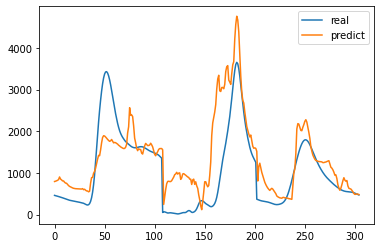

In [16]:
plt.figure()
plt.plot(scaled_test_label,label='real')
plt.plot(scaled_pred,label='predict')
plt.legend()
plt.show()

In [ ]:
cnnlstm.predict()

In [90]:
## knn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split

base='2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_데이터_210803/'
train_folder='01_제공데이터/'

data=pd.read_excel(base+train_folder+'2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_댐유입량,강우,수위데이터_210803.xlsx')

cols=['홍수사상번호','연','월','일','시간','유입량']

for i in range(1,7):
    prefix=f'데이터집단{i}_'
    cols.append(prefix+'유역평균강수')
    cols.append(prefix+'강우(A지역)')
    cols.append(prefix+'강우(B지역)')
    cols.append(prefix+'강우(C지역)')
    cols.append(prefix+'강우(D지역)')
    cols.append(prefix+'수위(E지역)')
    cols.append(prefix+'수위(B지역)')

data=data.drop(0).reset_index(drop=True)
data.columns=cols

for idx,col in enumerate(cols):
    if idx<5:
        data[col]=data[col].astype(int)
    else:
        data[col]=data[col].astype(float)    
        
from datetime import datetime,timedelta

data['time']=data.apply(lambda row:datetime(year=int(row['연']),month=int(row['월']),day=int(row['일'])),axis=1)
data['time']=data.apply(lambda row:row['time']+timedelta(hours=row['시간']),axis=1)

train=data.iloc[:2891]
test=data.iloc[2891:]

submit=test[['홍수사상번호','연','월','일','시간']]
submit['유입량']=0

train=train.drop(['홍수사상번호','연','월','일','시간','time'],axis=1)
test=test.drop(['유입량','홍수사상번호','연','월','일','시간','time'],axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [91]:
X=train.drop(['유입량'],axis=1).values

sc=StandardScaler()
X=sc.fit_transform(X)
test=sc.transform(test.values)
y=train['유입량'].values

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train.shape : {x_train.shape}, x_valid.shape : {x_test.shape}")
print(f"y_train.shape : {y_train.shape}, y_valid.shape : {y_test.shape}")

X_train.shape : (2312, 42), x_valid.shape : (579, 42)
y_train.shape : (2312,), y_valid.shape : (579,)


In [92]:
rmse_val = [] #to store rmse values for different k
for K in range(1,21):
    model = KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train, y_train)  #fit the model
    pred=model.predict(x_test) #make prediction on test set
    error = np.sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 232.6547230678413
RMSE value for k=  2 is: 176.47548093469916
RMSE value for k=  3 is: 221.31696790956653
RMSE value for k=  4 is: 235.66957665146003
RMSE value for k=  5 is: 272.1076740678118
RMSE value for k=  6 is: 308.50989549317677
RMSE value for k=  7 is: 346.76270623292464
RMSE value for k=  8 is: 365.8214408019657
RMSE value for k=  9 is: 393.0558350193128
RMSE value for k=  10 is: 417.35177463037144
RMSE value for k=  11 is: 449.3446761674151
RMSE value for k=  12 is: 472.0216672534249
RMSE value for k=  13 is: 497.400479027332
RMSE value for k=  14 is: 517.469181230883
RMSE value for k=  15 is: 550.2988243832541
RMSE value for k=  16 is: 574.1356423178441
RMSE value for k=  17 is: 600.2083931782771
RMSE value for k=  18 is: 619.1867370834932
RMSE value for k=  19 is: 632.1887955474454
RMSE value for k=  20 is: 649.7136880102631


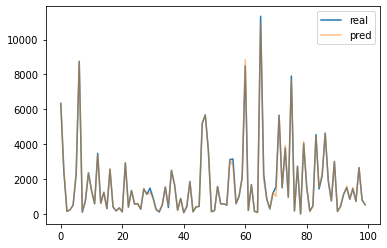

In [93]:
model=KNeighborsRegressor(n_neighbors = 2)

model.fit(x_train,y_train)

pred=model.predict(x_test)

plt.figure()
plt.plot(y_test[:100],label='real')
plt.plot(pred[:100],label='pred', alpha=0.5)
plt.legend()
plt.show()

In [96]:
pred=model.predict(test)
submit_knn=submit.copy()
submit_knn['유입량']=pred
submit_knn.head()

,홍수사상번호,연,월,일,시간,유입량
2891,26,2018,7,1,6,150.461248
2892,26,2018,7,1,7,155.299412
2893,26,2018,7,1,8,159.991283
2894,26,2018,7,1,9,168.820359
2895,26,2018,7,1,10,184.819845
